# <center>Классификация фильмов по жанрам
Данные взяты с [соревнования на *Kaggle*](https://www.kaggle.com/competitions/sf-dl-movie-genre-classification/overview)

Описание столбцов в датасете:

* `name` - название фильма
* `text` - описание фильма

Целевой признак:

* `genre` - жанр фильма

<a id='start'></a>

## <center>Знакомство с данными

In [64]:
import pandas as pd
import numpy as np

import itertools
import pickle
from IPython.display import Markdown

import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots

from wordcloud import WordCloud

import nltk

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
import keras

pio.renderers.default = 'png'
pio.templates.default = 'plotly_dark'
RANDOM_STATE = 42
N_JOBS = -1
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
data = pd.read_csv('../data/train.csv.zip')
display(
    Markdown('### Пример данных'),
    data.sample(3, random_state=RANDOM_STATE),
    Markdown(f'### Количество пропусков: {data.isna().sum().sum()}'),
    Markdown(f'### Количество дубликатов: {data.duplicated().sum()}'),
    Markdown('### Характеристики признаков'),
    data.describe().T
)

### Пример данных

,name,genre,text
5089,Sisterhood (2008),comedy,"Catherine St.John-Burke is an independent, up..."
30323,Idylle (1983),short,"Beginning of the century. In a train, a young..."
6415,The Lost Skeleton Returns Again (2009),comedy,"Jerranium 90, a ""little rock"" that made all t..."


### Количество пропусков: 0

### Количество дубликатов: 0

### Характеристики признаков

,count,unique,top,freq
name,54214,54214,Oscar et la dame rose (2009),1
genre,54214,27,drama,13613
text,54214,54086,Grammy - music award of the American academy ...,12


Напишем отдельный трансформер, чтобы удалить признак `name` и создать признак `year` - год выпуска фильма. Пропуски заполним медианой

In [5]:
class YearTransormer(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        
    def fit(self, X:pd.DataFrame, y=None):
        return self
    
    def transform(self, X:pd.DataFrame, y=None):
        X_copy = X.copy()
        X_copy['year'] = X_copy['name'].str.findall(r'\((.*)\)').apply(lambda year: year[0] if year[0].isnumeric() else None)
        X_copy['year'] = X_copy['year'].fillna(X_copy['year'].median()).astype(int)
        X_copy.drop(columns='name', inplace=True)
        return X_copy

Применим трансформер к данным и выведем результат

In [6]:
year_transformer = YearTransormer()
data_copy = year_transformer.fit_transform(data)
data_copy.sample(3, random_state=RANDOM_STATE)

,genre,text,year
5089,comedy,"Catherine St.John-Burke is an independent, up...",2008
30323,short,"Beginning of the century. In a train, a young...",1983
6415,comedy,"Jerranium 90, a ""little rock"" that made all t...",2009


<a id='visual'></a>

## <center>Визуальный анализ данных

<a id='visual_target'></a>

### Распределение целевого признака

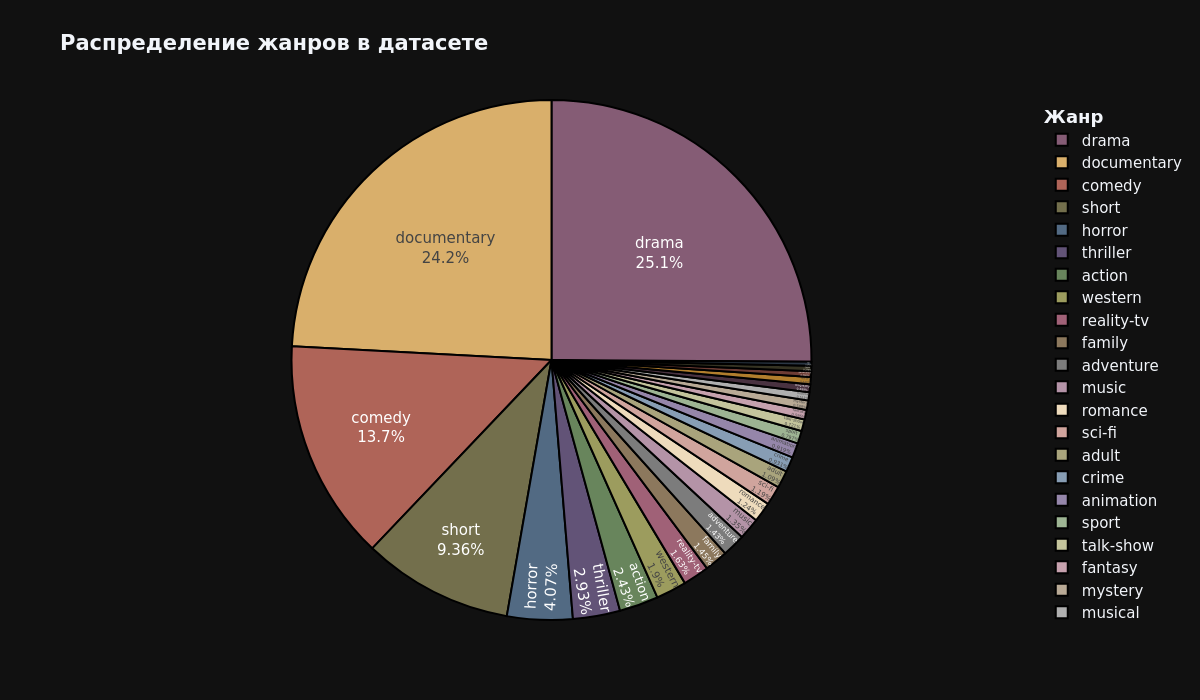

In [7]:
px.pie(
    data_frame=data_copy,
    names='genre',
    height=700,
    width=1200,
    color_discrete_sequence=px.colors.qualitative.Antique,
    title='<b>Распределение жанров в датасете</b>'
).update_traces(
    textinfo='percent+label',
    marker=dict(line=dict(color='black', width=2)), 
    textposition='inside'
).update_layout(legend_title='<b>Жанр</b>', font=dict(size=15))

Для удобства визуализируем топ-10 наиболее часто встречающихся жанров

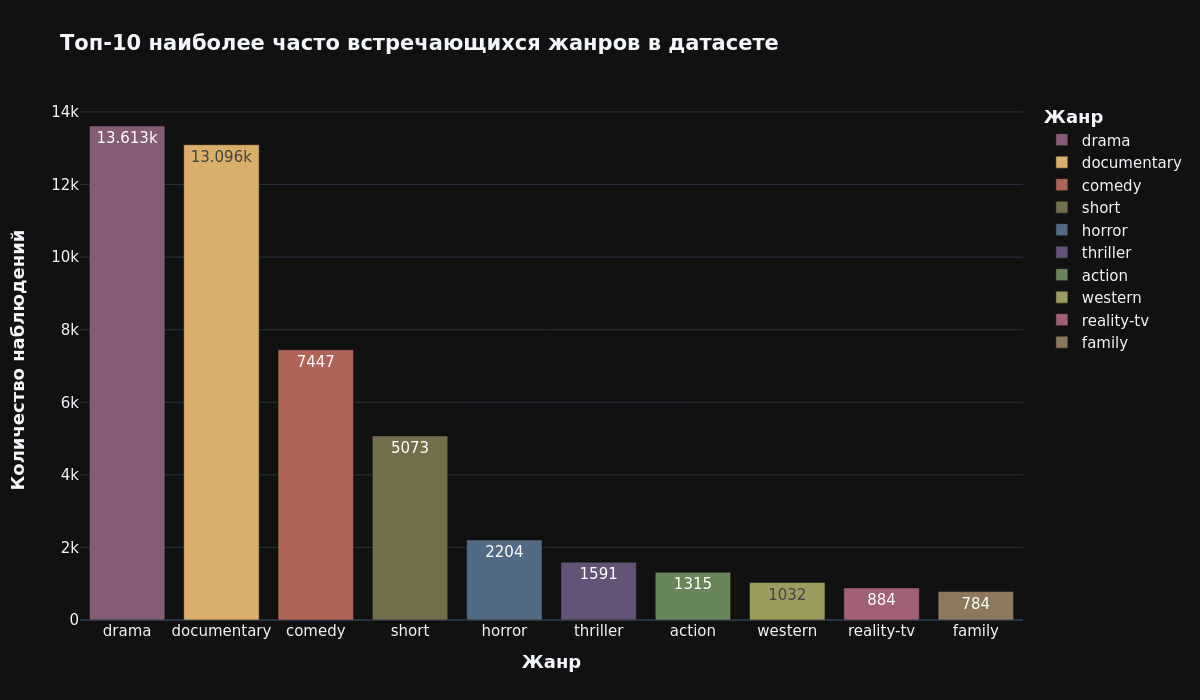

In [8]:
grouped_genre = data_copy.groupby('genre', as_index=False)['year'].count().sort_values(by='year', ascending=False).head(10)

px.bar(
    data_frame=grouped_genre,
    x='genre',
    y='year',
    color='genre',
    title='<b>Топ-10 наиболее часто встречающихся жанров в датасете</b>',
    color_discrete_sequence=px.colors.qualitative.Antique,
    text_auto=True,
    width=1200,
    height=700,
    labels={
        'genre': '<b>Жанр</b>',
        'year': '<b>Количество наблюдений</b>'
    }
).update_layout(font=dict(size=15))

<a id='visual_year'></a>

### Распределение признака `year`

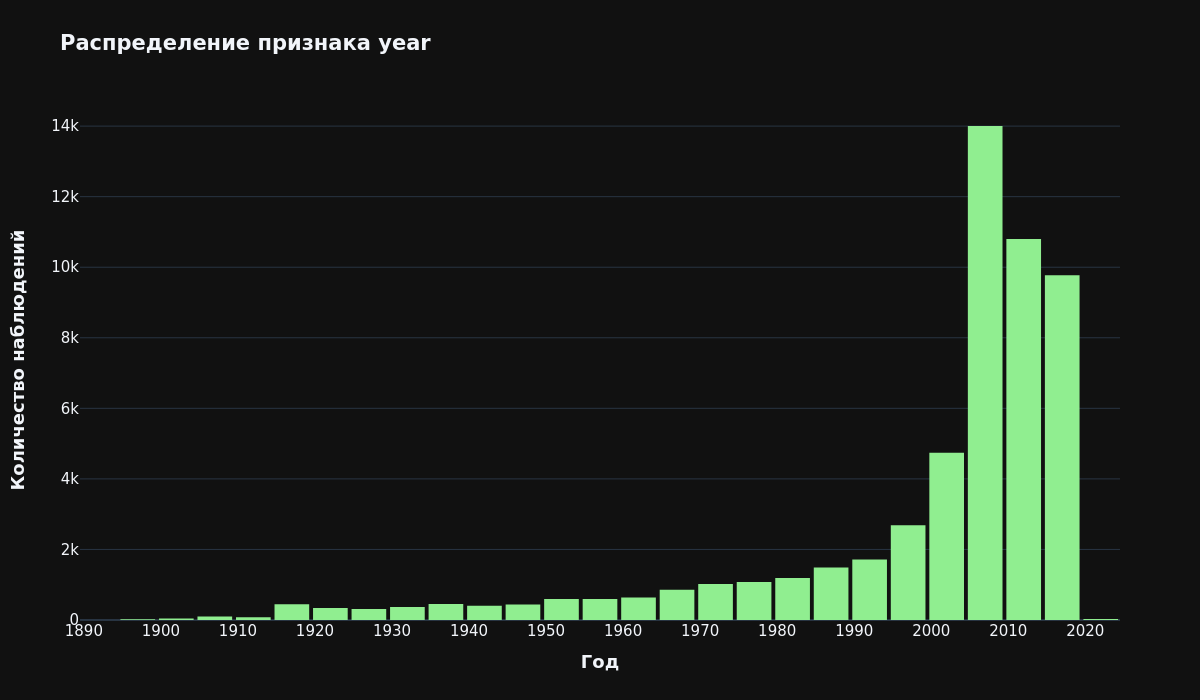

In [9]:
px.histogram(
    data_frame=data_copy,
    x='year',
    width=1200,
    height=700,
    nbins=50,
    color_discrete_sequence=['#90EE90'],
    title='<b>Распределение признака year</b>',
    labels=dict(year='<b>Год</b>')
).update_xaxes(
    tickformat='linear',
    dtick=10
).update_layout(
    bargap=0.1, 
    font=dict(size=15),
).update_yaxes(title='<b>Количество наблюдений</b>')

<a id='visual_wordcloud'></a>

### *Wordcloud* для каждого жанра
Сгруппируем жанры так, чтобы признак `text` для каждого жанра содержал все текста этого жанра

In [10]:
grouped_genre_by_text = data_copy.groupby(by='genre', as_index=False)['text'].sum()
grouped_genre_by_text

,genre,text
0,action,Dong-woo is released from prison after a shor...
1,adult,As the bus empties the students for their fie...
2,adventure,Fourteen-year-old Colm Bell and his 11-year-o...
3,animation,The story revolves around a bird called 'Humm...
4,biography,Set during the turmoil of post-Napoleonic Fra...
5,comedy,In tough economic times Max and Joey have all...
6,crime,Ron Petrie (Keanu Reeves) is a troubled teen ...
7,documentary,Quality Control consists of a series of 16mm ...
8,drama,Listening in to a conversation between his do...
9,family,Lyle Licketti never ever does his homework. W...


Создадим трансфомер `TextTransformer`, который делает следующие операции с признаком `text` в датафрейме при вызове метода `transform`:
* Приведение текста к нижнему регистру
* Удаление служебных символов
* Лемматизация
* Удаление стоп-слов 

In [11]:
class TextTransformer(TransformerMixin, BaseEstimator):
    def __init__(self) -> None:
        super().__init__()
        nltk.download('stopwords')
        nltk.download('wordnet')
    
    def fit(self, X:pd.DataFrame, y=None):
        self.stop_words = set(nltk.corpus.stopwords.words("english"))
        self.tokenizer = nltk.RegexpTokenizer(r'\w+')
        self.lemmatizer = nltk.stem.WordNetLemmatizer()
        return self
    
    def transform(self, X:pd.DataFrame, y=None):
        
        def filter_stop_words(text:str):
            filtered_list = [
                word for word in text.split()
                if word not in self.stop_words
            ]
            return ' '.join(filtered_list).strip()
        
        X_copy = X.copy()
        X_copy = X.apply(
            lambda string: string.lower()
        ).apply(
            lambda string: ' '.join(self.tokenizer.tokenize(string))
        ).apply(
            self.lemmatizer.lemmatize
        ).apply(
            filter_stop_words
        )
        
        return X_copy

Применим трансформер и взглянем на результат

In [12]:
text_transformer = TextTransformer()
grouped_genre_by_text['text'] = text_transformer.fit_transform(grouped_genre_by_text['text'])
grouped_genre_by_text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/screamer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/screamer/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,genre,text
0,action,dong woo released prison short time following ...
1,adult,bus empties students field trip museum natural...
2,adventure,fourteen year old colm bell 11 year old sister...
3,animation,story revolves around bird called hummi happy ...
4,biography,set turmoil post napoleonic france story cente...
5,comedy,tough economic times max joey run ideas discov...
6,crime,ron petrie keanu reeves troubled teen whose li...
7,documentary,quality control consists series 16mm single ta...
8,drama,listening conversation doctor parents 10 year ...
9,family,lyle licketti never ever homework whether alie...


Теперь можно визуализировать *WordCloud* для жанров

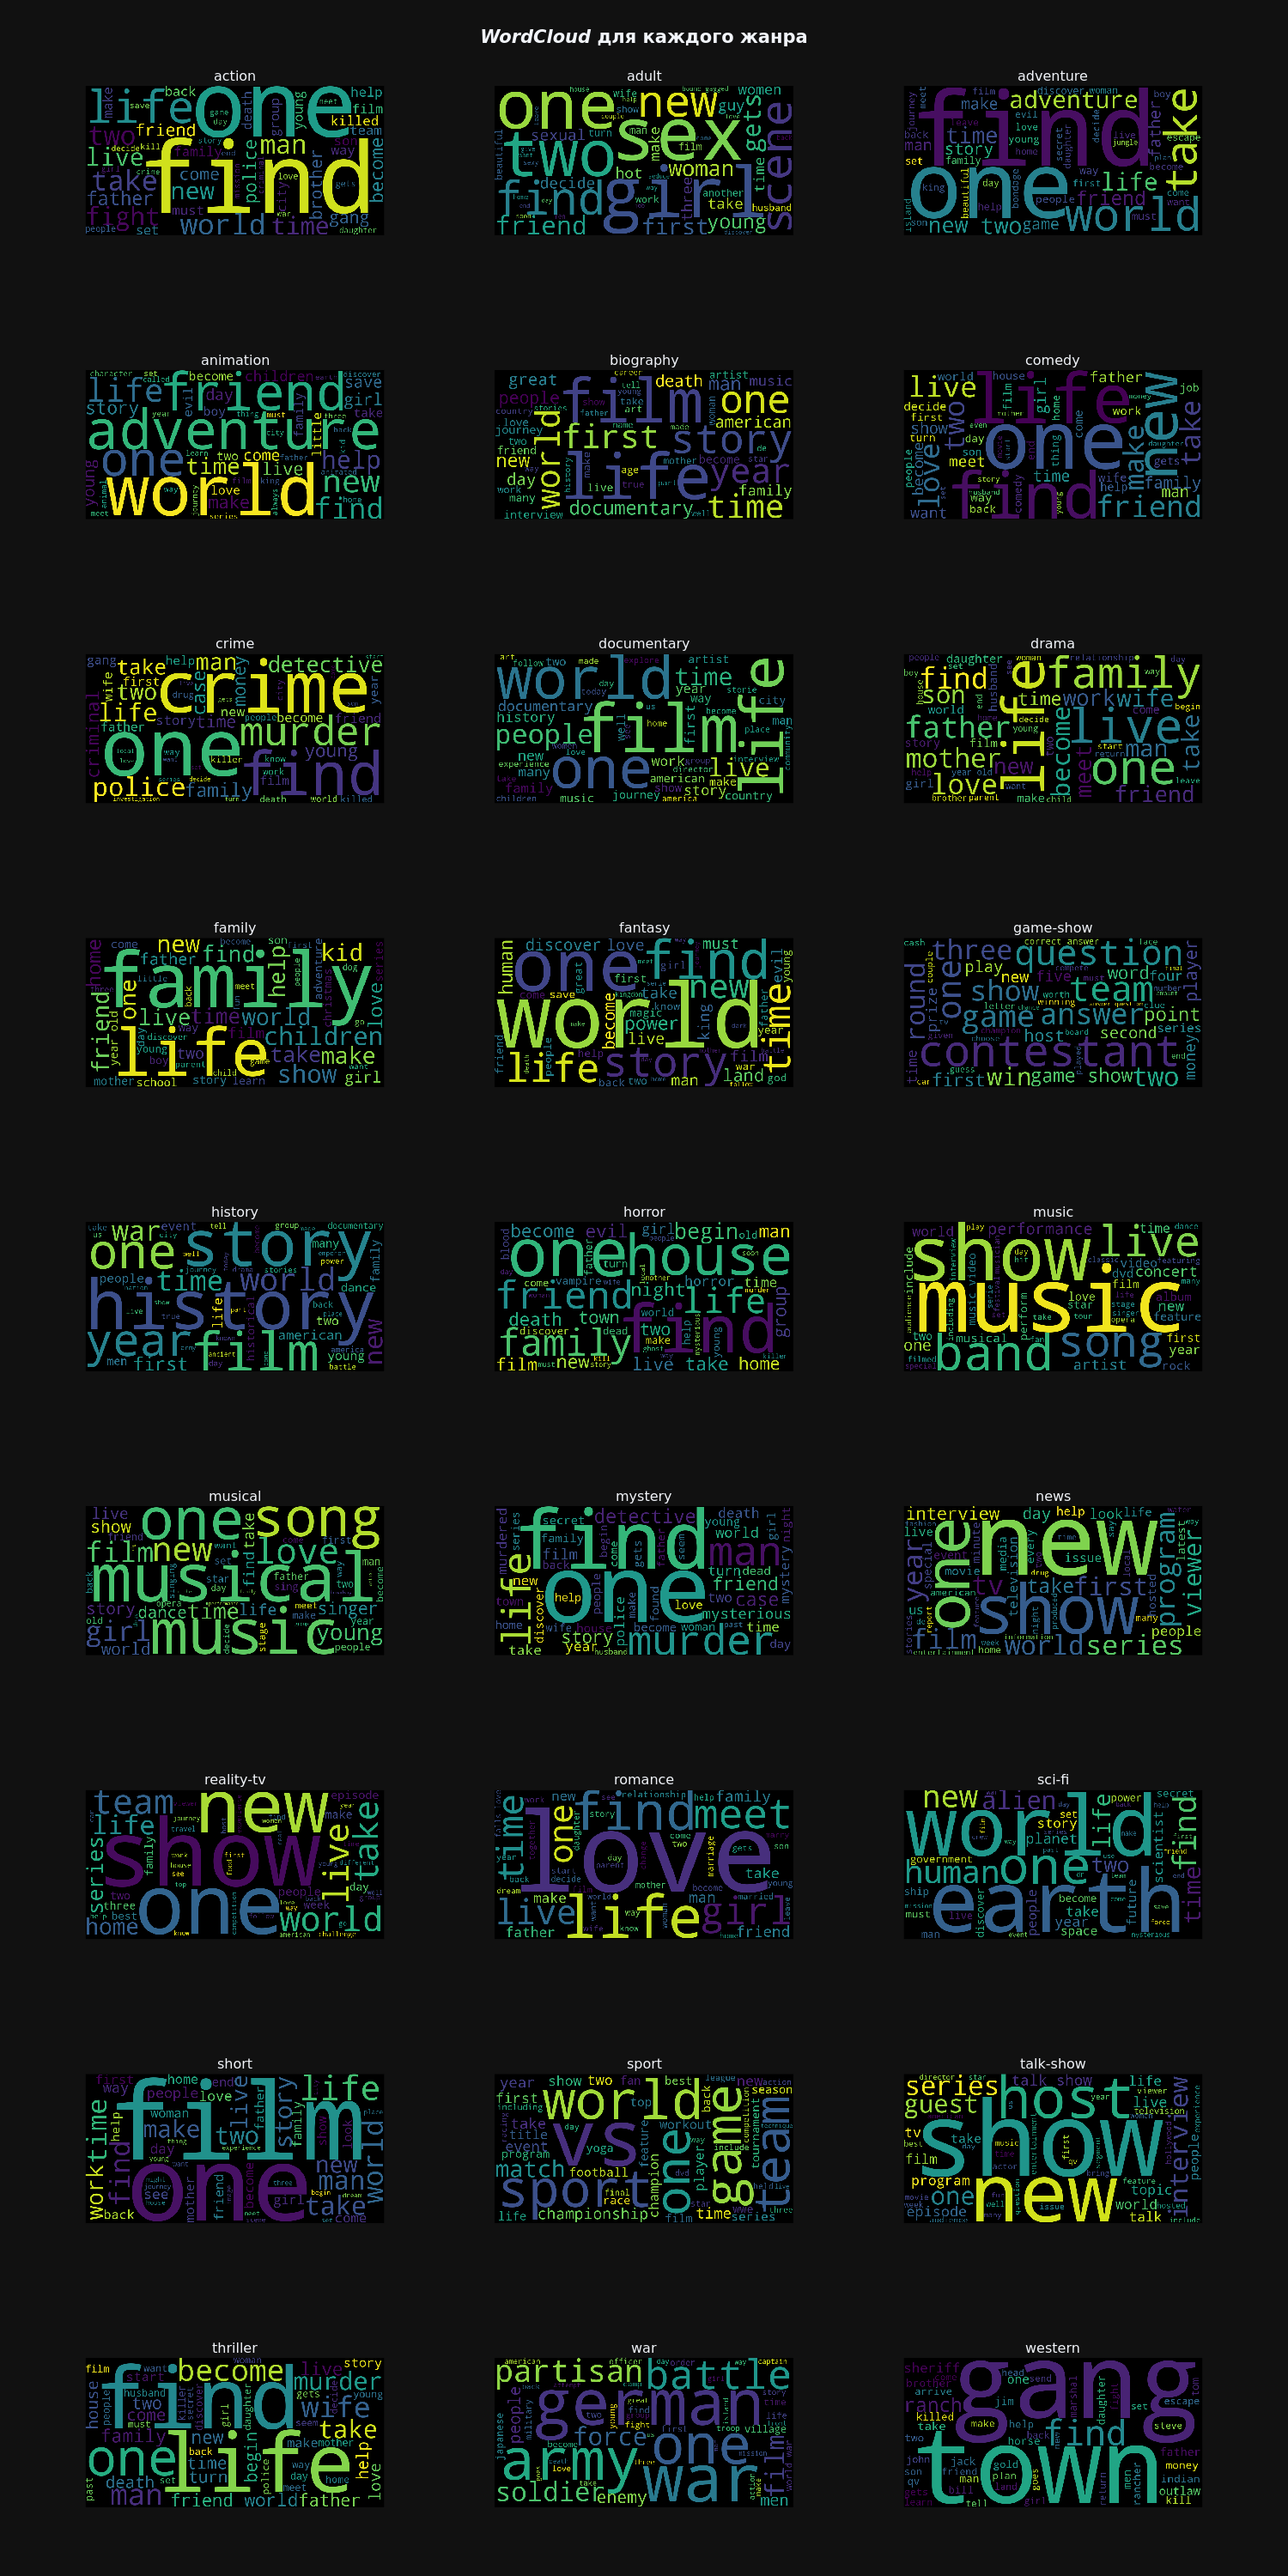

In [13]:
plots_grid = make_subplots(
    rows=9,
    cols=3,
    subplot_titles=grouped_genre_by_text['genre'].unique()
)
wc = WordCloud(
    width=1000, 
    height=500,
    colormap='viridis',
    max_words=50,
    min_font_size=6,
    min_word_length=2
)
iterators = (
    sorted(list(range(1, 10)) * 3), 
    itertools.cycle(range(1, 4)), 
    range(0, 28)
)
counter = 0

for row, col, idx in zip(*iterators):
    img = px.imshow(wc.generate(grouped_genre_by_text.loc[idx, 'text']), width=1000, height=500).data[0]
    plots_grid.add_trace(img, row=row, col=col)
    counter += 1
    if counter == grouped_genre_by_text['genre'].nunique():
        break

plots_grid.update_layout(
    height=3000,
    width=1500,
    font=dict(size=15),
    title='<b><i>WordCloud</i> для каждого жанра</b>',
    title_x=0.5
).update_xaxes(
    visible=False
).update_yaxes(
    visible=False
)

<a id='eda'></a>

## <center>EDA
Напишем трансформер `text_preprocessing` из следующих преобразований:
1. Отфильтровать текст с помощью `TextTransformer`:
    * Приведение к нижнему регистру
    * Удаление служебных символов
    * Лемматизация
2. Векторизация текста методом $\text{TF-IDF}$ с помощью `TfidfVectorizer`. Корпус ограничим до 100 тыс. слов

In [14]:
tf_idf = TfidfVectorizer(
    input='content',
    lowercase=False,
    analyzer='word',
    max_features=100_000
)
text_preprocessing = make_pipeline(
    text_transformer,
    tf_idf
)

In [15]:
X, y = text_preprocessing.fit_transform(data['text']), data['genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=RANDOM_STATE)
print(
    f'Размер обучающей выборки: {X_train.shape}\n',
    f'Размер тестовой выборки: {X_test.shape}',
    end='', 
    sep=''
)

Размер обучающей выборки: (37949, 100000)
Размер тестовой выборки: (16265, 100000)

<a id='ml'></a>

## <center>ML
Для начала напишем функцию, которая будет отображать метрики для моделей, а так же записывать все результаты в словарь 

In [16]:
# Функция, которая выводит значение accuracy и f1-score исследуемых моделей
def print_metrics(model) -> None:
    # Делаем предсказания для выборок и вычисляем метрики
    y_pred_train = model.fit(X_train, y_train).predict(X_train)
    y_pred_test = model.predict(X_test)
    f1_train = f1_score(y_train, y_pred_train, average='macro')
    f1_test = f1_score(y_test, y_pred_test, average='macro')
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    # Имя модели
    model_name = model.__class__.__name__
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    # Отображаем информацию для конкретной модели
    display(Markdown(
        f'Значение метрики $F_1-score$ при использовании *{model_name}*:<br> \
        <ul><li>train: ${f1_train:.3f}$</li><li>test: ${f1_test:.3f}$</li></ul><br> \
        Значение метрики $Accuracy$ при использовании *{model_name}*:<br> \
        <ul><li>train: ${accuracy_train:.3f}$</li><li>test: ${accuracy_test:.3f}$</li></ul>'
    ))
    # Визуализируем матрицу ошибок
    px.imshow(
        conf_matrix,
        x=model.classes_,
        y=model.classes_,
        width=1200,
        height=1200,
        color_continuous_scale=px.colors.diverging.RdBu_r,
        text_auto=True,
        title='<b>Confusion matrix</b>'
    ).show()

<a id='ml_logreg'></a>

### *LogisticRegression*

Значение метрики $F_1-score$ при использовании *LogisticRegression*:<br>         <ul><li>train: $0.381$</li><li>test: $0.236$</li></ul><br>         Значение метрики $Accuracy$ при использовании *LogisticRegression*:<br>         <ul><li>train: $0.717$</li><li>test: $0.573$</li></ul>

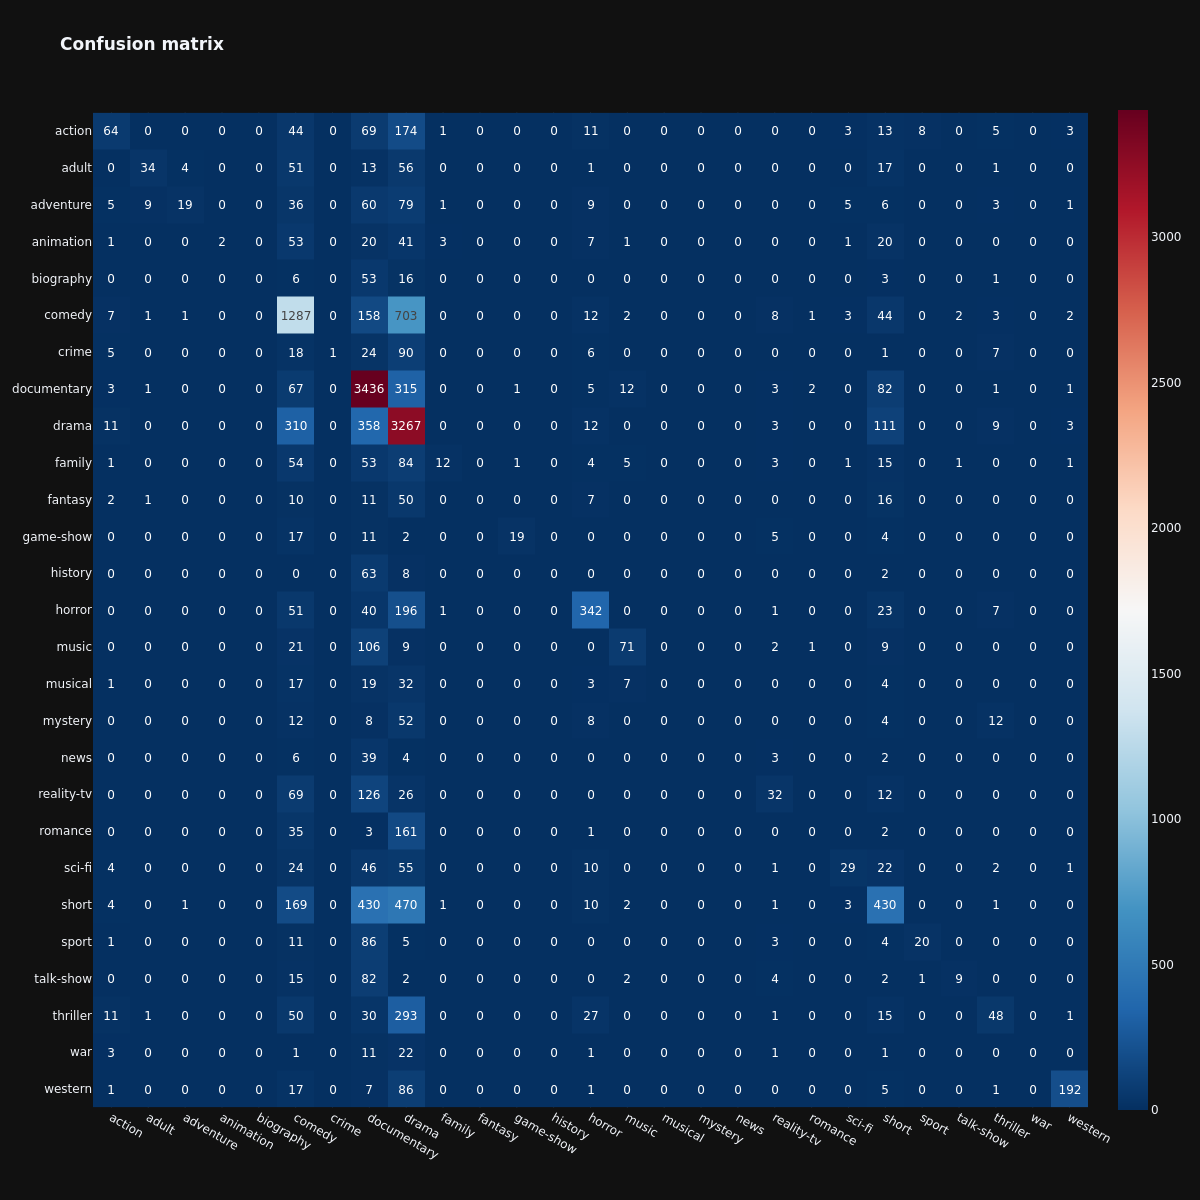

In [17]:
logreg_model = LogisticRegression(max_iter=10000, random_state=RANDOM_STATE)
print_metrics(logreg_model)

На тестовых данных модель показала довольно неплохое качество $Accuracy$, попробуем градиетный спуск

<a id='ml_sgd'></a>

### *SGDClassifier*

Значение метрики $F_1-score$ при использовании *SGDClassifier*:<br>         <ul><li>train: $0.706$</li><li>test: $0.277$</li></ul><br>         Значение метрики $Accuracy$ при использовании *SGDClassifier*:<br>         <ul><li>train: $0.776$</li><li>test: $0.573$</li></ul>

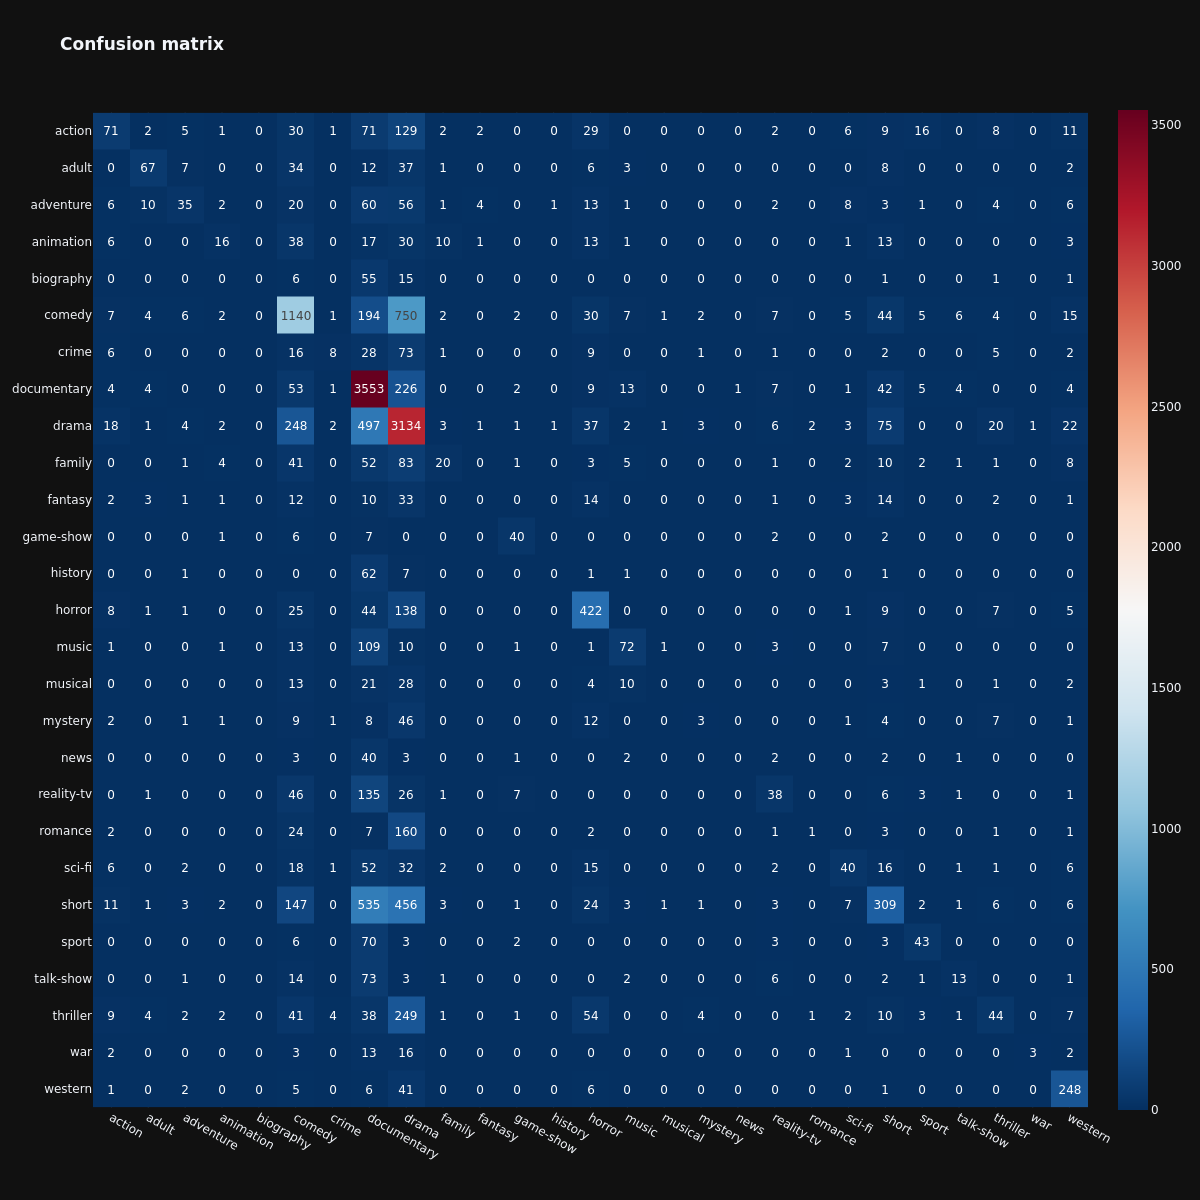

In [18]:
sgd_clf = SGDClassifier(random_state=RANDOM_STATE, max_iter=100000)
print_metrics(sgd_clf)

Метрики практически не поменялись, проверим наивные байесовские методы

<a id='ml_mnb'></a>

### *MultinomialNB*

Значение метрики $F_1-score$ при использовании *MultinomialNB*:<br>         <ul><li>train: $0.053$</li><li>test: $0.047$</li></ul><br>         Значение метрики $Accuracy$ при использовании *MultinomialNB*:<br>         <ul><li>train: $0.470$</li><li>test: $0.444$</li></ul>

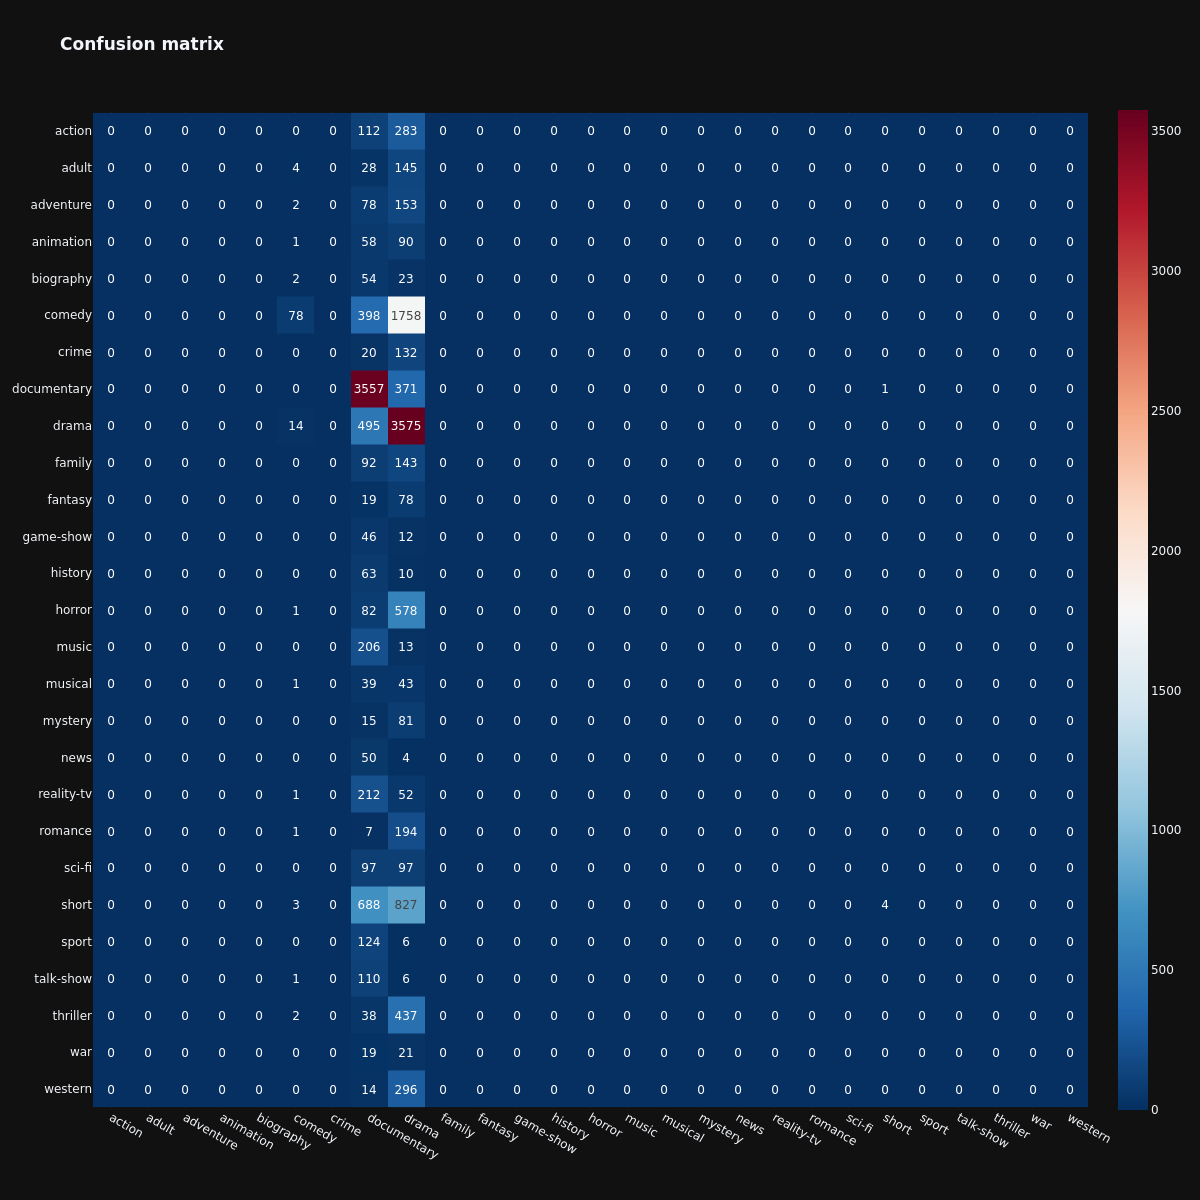

In [19]:
mnb = MultinomialNB()
print_metrics(mnb)

<a id='ml_cnb'></a>

### *ComplementNB*

Значение метрики $F_1-score$ при использовании *ComplementNB*:<br>         <ul><li>train: $0.497$</li><li>test: $0.190$</li></ul><br>         Значение метрики $Accuracy$ при использовании *ComplementNB*:<br>         <ul><li>train: $0.688$</li><li>test: $0.521$</li></ul>

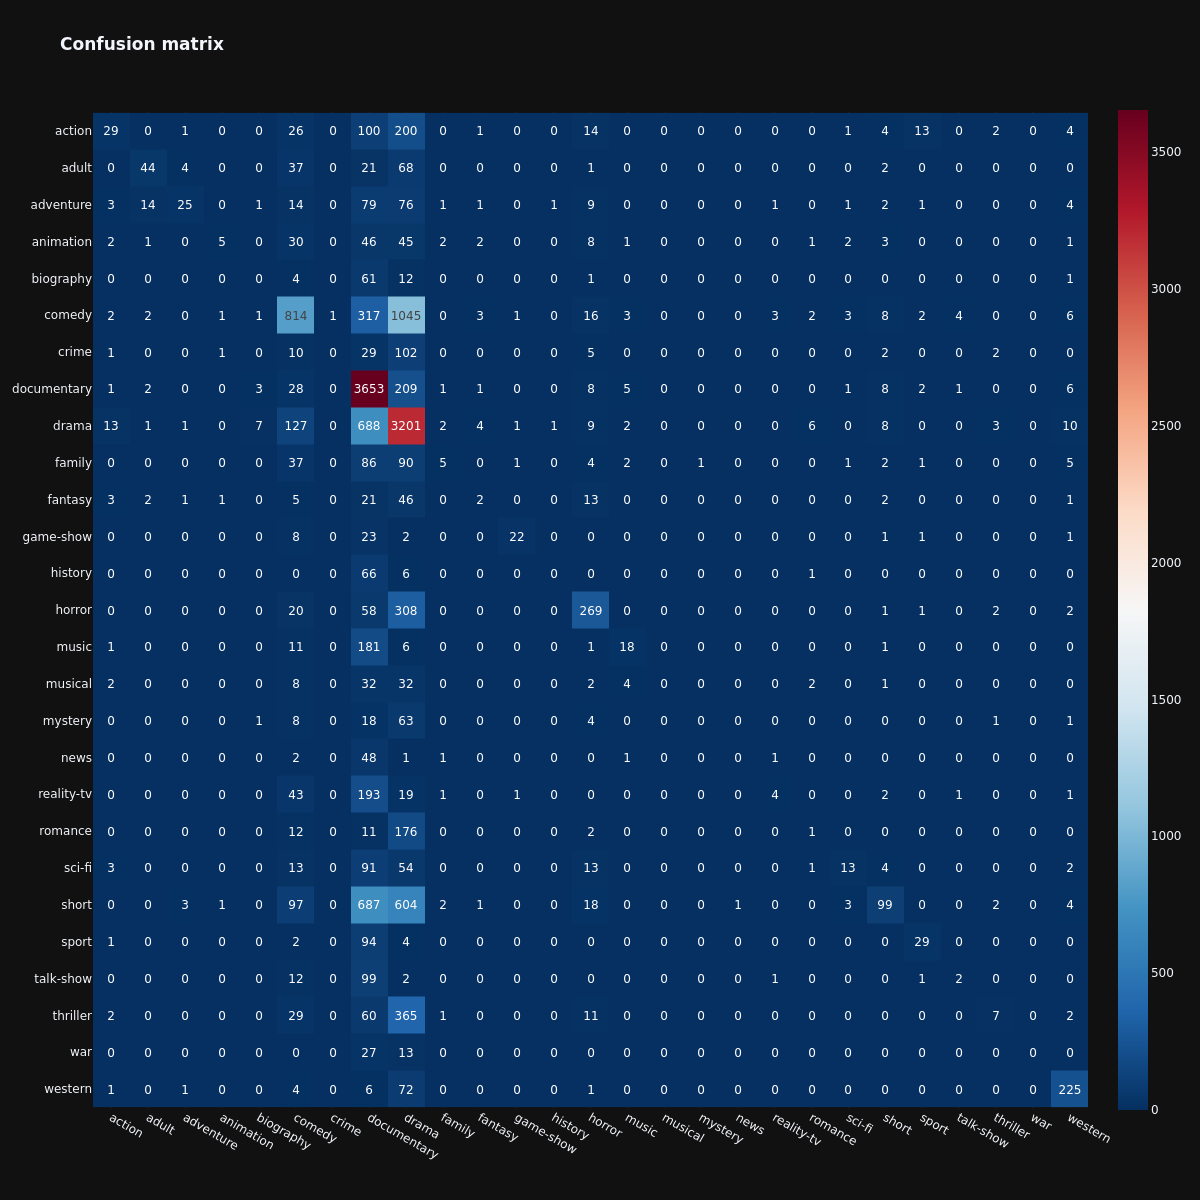

In [20]:
cnb = ComplementNB()
print_metrics(cnb)

Оба байесовских подхода показали менее удовлетворительный результат, чем логистическая регрессия

Т.к. у нас классификация текстов (задача *NLP*), то лучше всего для этого подходит **глубокое обучение**

<a id='ml_cnb'></a>

## <center>*DeepLearning*
Возьмем только необходимые данные для обучения

In [3]:
X, y = data['text'], data['genre']

Разделим выборки на обучающую и валидационную в соотношении 80:20, также используем стратификацию, чтобы количество экземпляров каждого класса в выборках было одинаковым

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

print(len(X_train), 'training examples')
print(len(X_val), 'validation examples')

43371 training examples
10843 validation examples


Подготовим данные для обучения:
* Конвертируем матрицу наблюдений (в нашем случае это вектор, состоящий из текста) в тензор
* Целевой признак закодируем сначала с помощью `LabelEncoder` (категориальное кодирование классов в численное представление), а потом с помощью *OneHot*-кодирования создадим из вектора матрицу правильных ответов

In [5]:
train_x, val_x = [
    tf.constant(X_train),
    tf.constant(X_val)
]

label_encoder = LabelEncoder().fit(data['genre'])

train_y = keras.utils.to_categorical(label_encoder.transform(y_train))
val_y = keras.utils.to_categorical(label_encoder.transform(y_val))

2023-12-01 13:24:36.212487: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-01 13:24:36.212609: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-01 13:24:36.212648: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-01 13:24:36.399381: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-01 13:24:36.399547: I external/local_xla/xla/stream_executor

Будем использовать наиболее популярную в *NLP* модель *BERT*. У неё есть несколько вариаций, я возьму модель, которая на выходе имеет **768 нейронов**:
* Первый слой `text_input` - наш текст, который необходимо подать в модель
* Второй слой `preprocessor` - часть *BERT*, векторизация текста, скачаем готовое решение
* Четвертый слой `encoder` - предобученная нейросеть *BERT*. На выходе нас интересует только `pooled_output` - 768-мерное представление входных данных
* Пятый слой `dropout_layer` - регуляризация 30% нейронов
* Шестой слой `output_layer` - выходной слой из 27 нейронов (количество классов) с активацией `softmax` для мультиклассовой классификации. У наиболее вероятного класса будет наибольшая вероятность, так что можно будет взять $\argmax$ и получить предсказание

In [6]:
text_input = keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer('https://kaggle.com/models/tensorflow/bert/frameworks/TensorFlow2/variations/en-uncased-preprocess/versions/3')
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer('https://www.kaggle.com/models/tensorflow/bert/frameworks/tensorFlow2/variations/bert-en-uncased-l-12-h-768-a-12/versions/2', trainable=True)
outputs = encoder(encoder_inputs)['pooled_output']
n_classes = len(label_encoder.classes_)
dropout_layer = keras.layers.Dropout(0.3)(outputs)
output_layer = keras.layers.Dense(n_classes, activation='softmax')(dropout_layer)
# Инициализируем модель
model = keras.Model(inputs=[text_input], outputs=[output_layer])

Добавим коллбек для чекпоинтов: если на какой-то эпохе будет наилучшая метрика, то необходимо в конце обучения откатиться к этой эпохе с наилучшим результатом на валидационной выборке

Компилируем модель:
* В качестве оптимизатора возьмем `AdamW` - модификация `Adam`, решающая проблему затухающих весов. К тому же, именно этот оптимизатор использовался на обучении оригинального *BERT*. Темп обучения `learning_rate` возьмем очень низким ($10^{-6}$), т.к. мы не с нуля обучаем модель, а занимаемся *Fine tuning*. Необходимо просто немного подкорректировать веса нейронов для нашей задачи
* Функция потерь - логистическая функция потерь для классификации
* Метрики:
    * Точность (*Accuracy* для всего датасета, а не *Precision*). Именно эта метрика используется как целевая в соревановании на *Kaggle*
    * $F_1$-мера - среднее гармоническое для *Precision* и *Recall*

In [7]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True
)

model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=1e-6),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[
        keras.metrics.CategoricalAccuracy(),
        keras.metrics.F1Score()
    ]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_type_ids': (None,    0         ['input_1[0][0]']             
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

Необходимо обучить $\approx 10^8$ параметров. Размер батча возьмем равным 32 объекта, обучим 10 раз (10 эпох). Благодаря *GPU*-ускорению на *CUDA* ядрах это скорее всего займет несколько часов на видеокарте *RTX 3080 Ti*.  

In [8]:
batch_size = 32
epochs = 10

history = model.fit(
    train_x, train_y,
    epochs=epochs,
    validation_data=[val_x, val_y],
    batch_size=batch_size,
    callbacks=[model_checkpoint_callback],
    use_multiprocessing=True
)

Epoch 1/10


2023-12-01 13:25:40.269831: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-01 13:25:42.146049: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8f9c002720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-01 13:25:42.146088: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2023-12-01 13:25:42.156218: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-01 13:25:42.180398: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
I0000 00:00:1701426342.247965   26420 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1356/1356 [==============================] - 515s 359ms/step - loss: 2.1454 - categorical_accuracy: 0.4156 - f1_score: 0.0784 - val_loss: 1.6653 - val_categorical_accuracy: 0.5261 - val_f1_score: 0.1162
Epoch 2/10
1356/1356 [==============================] - 493s 363ms/step - loss: 1.6385 - categorical_accuracy: 0.5423 - f1_score: 0.1649 - val_loss: 1.4536 - val_categorical_accuracy: 0.5787 - val_f1_score: 0.2025
Epoch 3/10
1356/1356 [==============================] - 492s 363ms/step - loss: 1.4715 - categorical_accuracy: 0.5811 - f1_score: 0.2263 - val_loss: 1.3500 - val_categorical_accuracy: 0.6026 - val_f1_score: 0.2573
Epoch 4/10
1356/1356 [==============================] - 492s 363ms/step - loss: 1.3746 - categorical_accuracy: 0.6029 - f1_score: 0.2686 - val_loss: 1.2966 - val_categorical_accuracy: 0.6139 - val_f1_score: 0.2888
Epoch 5/10
1356/1356 [==============================] - 495s 365ms/step - loss: 1.3035 - categorical_accuracy: 0.6173 - f1_score: 0.3028 - val_loss: 1.2499

Визуализируем изменение функции потерь и целевой метрики во время обучения в зависимости от эпохи

In [27]:
def visualize_history(history):
    history_df = pd.DataFrame({
        'loss': history.history['loss'] + history.history['val_loss'],
        'accuracy': history.history['categorical_accuracy'] + history.history['val_categorical_accuracy'],
        'sample': ['train']*epochs + ['validation']*epochs,
        'epoch': list(range(1, epochs+1))*2
    })
    best_epoch_loss = history_df[history_df['sample'] == 'validation']['loss'].argmin() + 1
    best_epoch_acc = history_df[history_df['sample'] == 'validation']['accuracy'].argmax() + 1
    min_loss = history_df[history_df['sample'] == 'validation']['loss'].min()
    max_accuracy = history_df[history_df['sample'] == 'validation']['accuracy'].max()
    
    px.line(
        data_frame=history_df,
        x='epoch',
        y='loss',
        color='sample',
        width=900,
        height=600,
        title='История изменения функции потерь в зависимости от эпохи'
    ).update_layout(
        font=dict(size=15)
    ).add_vline(
        x=best_epoch_loss,
        line_dash='dash',
        opacity=0.5
    ).add_hline(
        y=min_loss,
        line_dash='dash',
        opacity=0.5
    ).add_annotation(
        x=best_epoch_loss,
        y=min_loss,
        text=f'min loss={min_loss:.3f}',
        arrowwidth=2,
        ax=20,
        arrowhead=2,
        bgcolor='white',
        font_color='black',
        ay=50
    ).show()
    
    px.line(
        data_frame=history_df,
        x='epoch',
        y='accuracy',
        color='sample',
        width=900,
        height=600,
        title='История изменения метрики <i>accuracy</i> в зависимости от эпохи'
    ).update_layout(
        font=dict(size=15)
    ).add_vline(
        x=best_epoch_acc,
        line_dash='dash',
        opacity=0.5
    ).add_hline(
        y=max_accuracy,
        line_dash='dash',
        opacity=0.5
    ).add_annotation(
        x=best_epoch_acc,
        y=max_accuracy,
        text=f'max accuracy={max_accuracy:.3f}',
        arrowwidth=2,
        ax=20,
        arrowhead=2,
        bgcolor='white',
        font_color='black',
        ay=-30
    ).show()

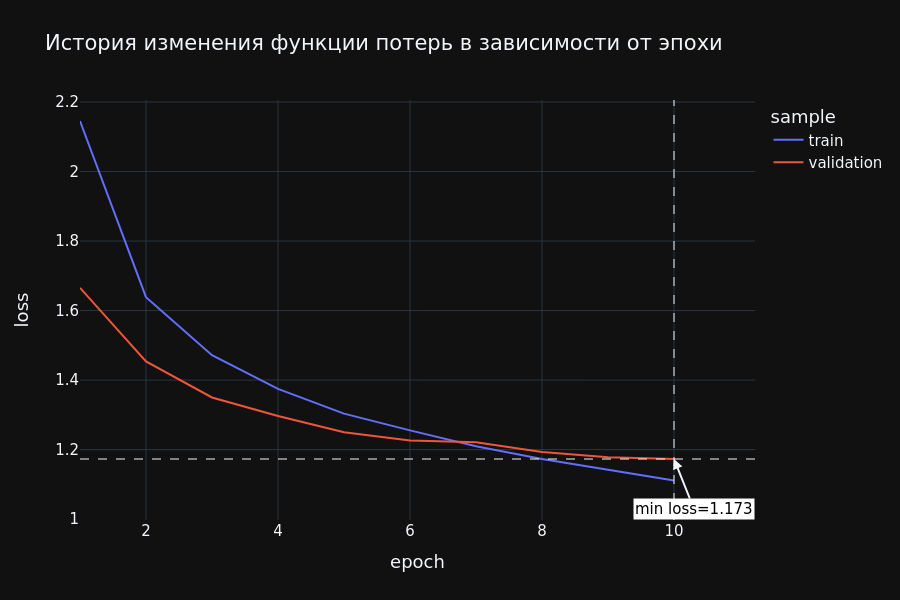

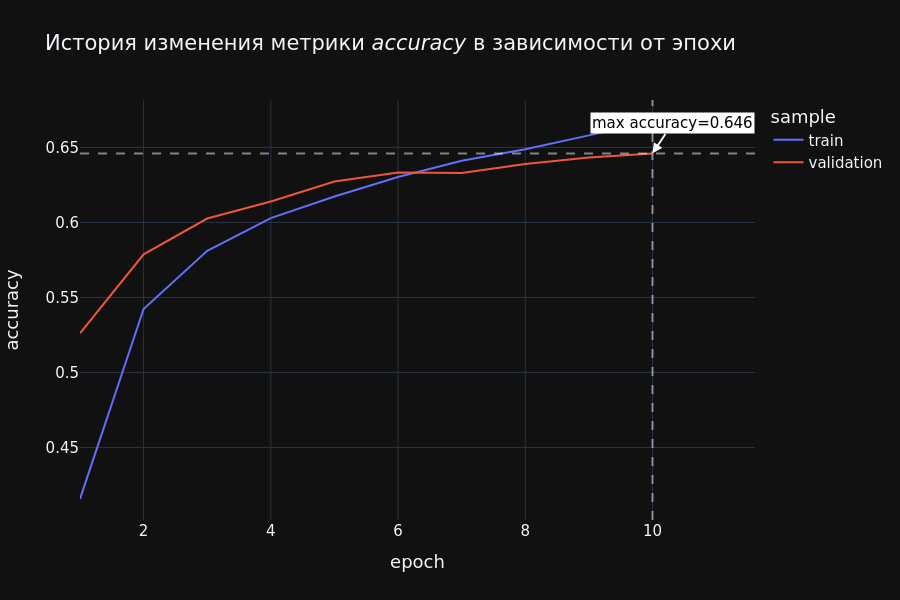

In [22]:
visualize_history(history)

Видно, что при таком низком `learning_rate` нам не хватило 10 эпох, чтобы сойтись к минимуму (на валидационной выборке). Дообучим модель ещё на 5-ти эпохах

In [23]:
epochs = 5

history = model.fit(
    train_x, train_y,
    epochs=epochs,
    validation_data=[val_x, val_y],
    batch_size=batch_size,
    callbacks=[model_checkpoint_callback],
    use_multiprocessing=True
)

Epoch 1/5
1356/1356 [==============================] - 511s 377ms/step - loss: 1.0834 - categorical_accuracy: 0.6731 - f1_score: 0.4170 - val_loss: 1.1595 - val_categorical_accuracy: 0.6504 - val_f1_score: 0.3960
Epoch 2/5
1356/1356 [==============================] - 511s 377ms/step - loss: 1.0557 - categorical_accuracy: 0.6792 - f1_score: 0.4263 - val_loss: 1.1620 - val_categorical_accuracy: 0.6492 - val_f1_score: 0.3976
Epoch 3/5
1356/1356 [==============================] - 565s 417ms/step - loss: 1.0322 - categorical_accuracy: 0.6867 - f1_score: 0.4371 - val_loss: 1.1584 - val_categorical_accuracy: 0.6488 - val_f1_score: 0.4066
Epoch 4/5
1356/1356 [==============================] - 483s 356ms/step - loss: 1.0046 - categorical_accuracy: 0.6969 - f1_score: 0.4515 - val_loss: 1.1592 - val_categorical_accuracy: 0.6544 - val_f1_score: 0.4091
Epoch 5/5
1356/1356 [==============================] - 482s 355ms/step - loss: 0.9868 - categorical_accuracy: 0.7005 - f1_score: 0.4614 - val_loss: 

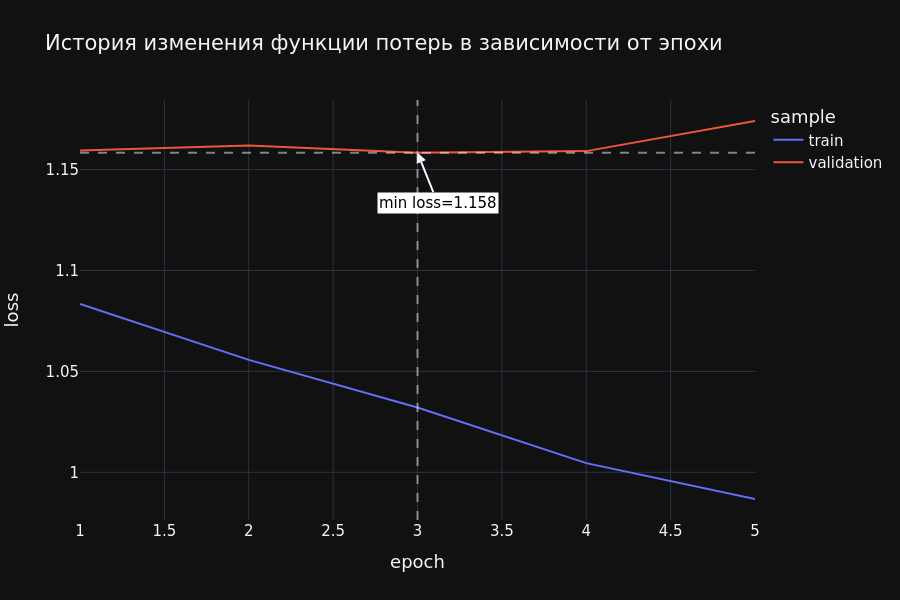

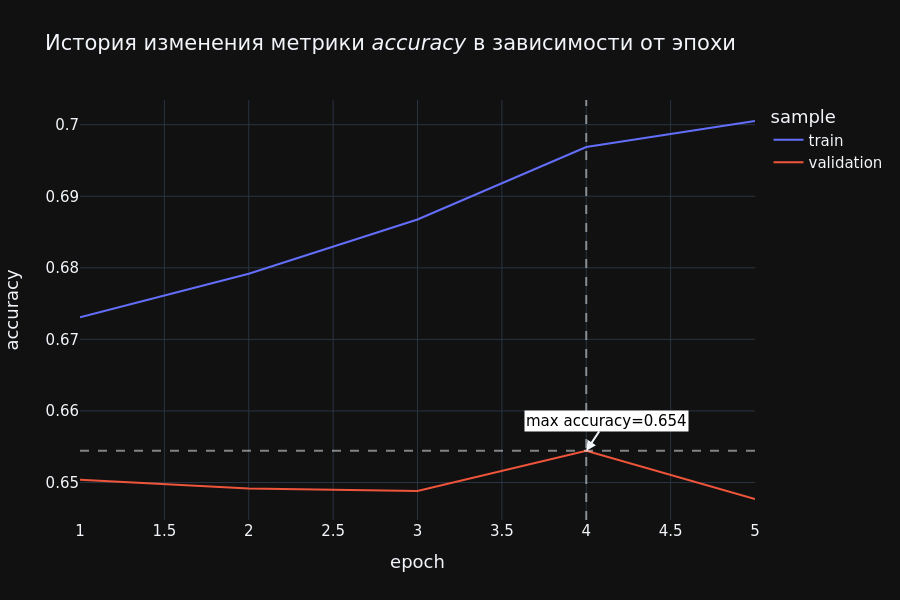

In [28]:
visualize_history(history)

После 14-й эпохи началось явное переобучение: метрика и значение функции потерь стали улучшаться на обучающей выборке, но при этом ухудшаться на валидационной - явный признак **переобучения**

**Откатимся к весам на 14-ей эпохе** (до того, как модель начала переобучаться), сохраним модель в файл. Также сохраним `label_encoder`, в котором хранятся классы, чтобы при деплое можно было сделать `inverse_transform` для предсказанных вероятностей

In [29]:
model.load_weights(checkpoint_filepath)
model.save(r'../model/bert_tuned.h5')
with open(r'../model/le_encoder.pkl', 'wb') as le_encoder_file:
    pickle.dump(label_encoder, le_encoder_file)

Визуализируем матрицу ошибок для валидационной выборки

339/339 [==============================] - 57s 165ms/step


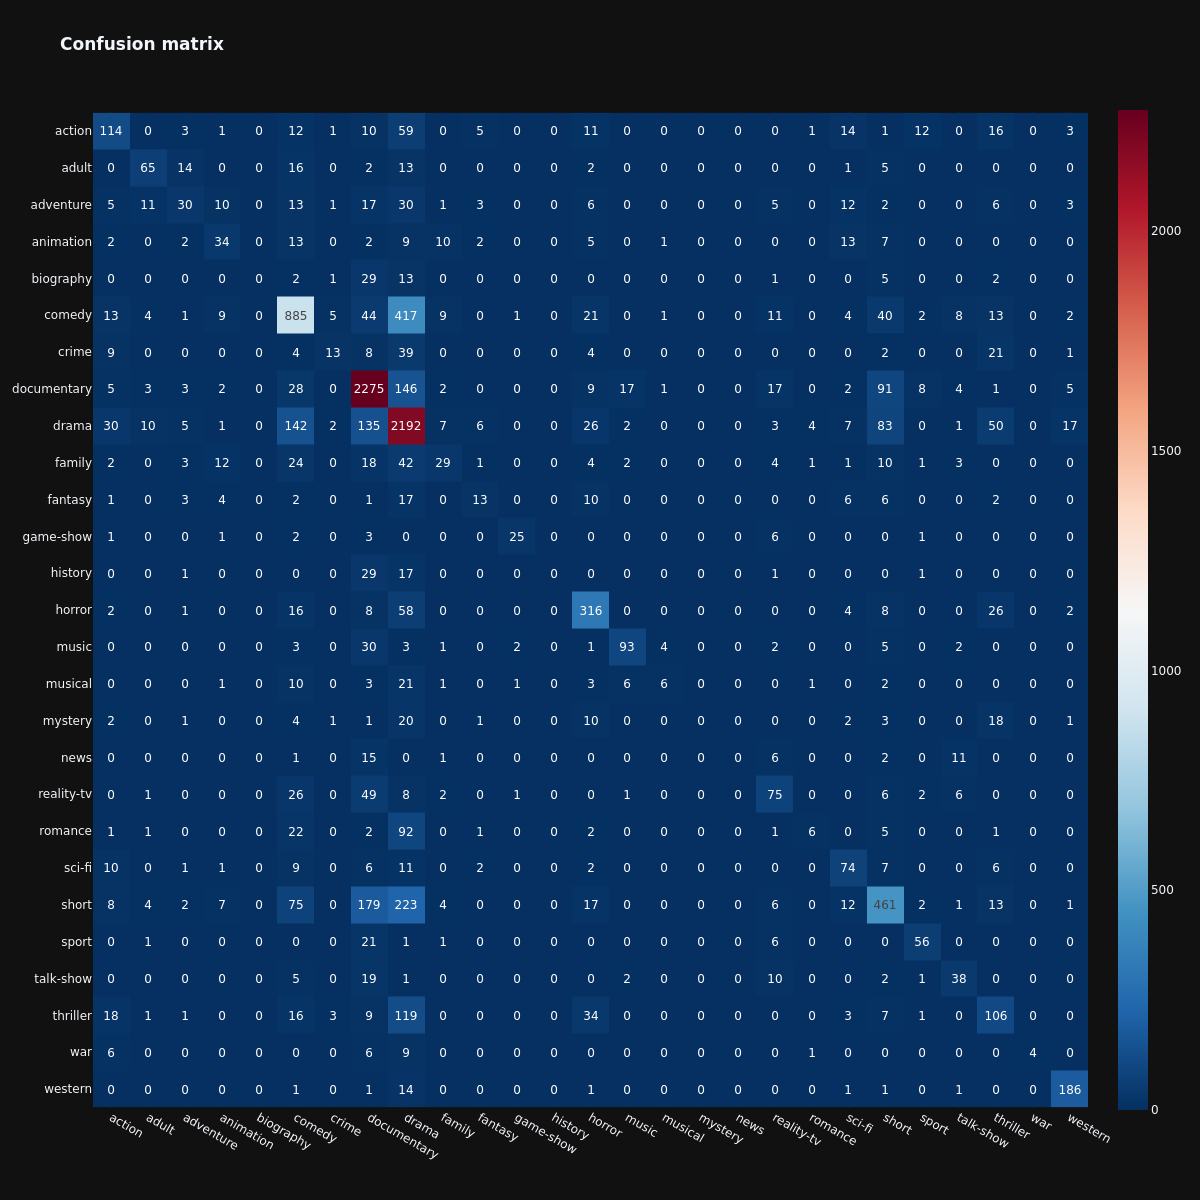

In [30]:
val_predictions = model.predict(val_x)
val_predictions_transformed = label_encoder.inverse_transform(val_predictions.argmax(axis=1))
val_true_transformed = label_encoder.inverse_transform(val_y.argmax(axis=1))

conf_matrix = confusion_matrix(val_true_transformed, val_predictions_transformed)
px.imshow(
    conf_matrix,
    x=label_encoder.classes_,
    y=label_encoder.classes_,
    width=1200,
    height=1200,
    color_continuous_scale=px.colors.diverging.RdBu_r,
    text_auto=True,
    title='<b>Confusion matrix</b>'
).show()

Делаем предсказание для тестовой выборки на *Kaggle*, чтобы сделать *submission*

In [31]:
test_data = pd.read_csv('../data/test.csv.zip')['text']
predictions = model.predict(test_data)
predictions_final = pd.DataFrame(label_encoder.inverse_transform(predictions.argmax(axis=1))).reset_index().rename(columns={
    'index': 'id',
    0: 'genre'
})
predictions_final['id'] = predictions_final['id'] + 1
predictions_final.to_csv('../data/predictions_v4.csv', index=False)

1694/1694 [==============================] - 282s 166ms/step


Немного протестируем нашу модель. Я взял несколько описаний разных фильмов из википедии, чтобы получить предсказание жанра для каждого из них

In [59]:
prediction = lambda desc: label_encoder.inverse_transform(model.predict(desc, verbose=0).argmax(axis=1))[0]

avengers_desc = [
    """Avengers: Endgame is a 2019 American superhero film based on the Marvel Comics superhero team the Avengers. Produced by Marvel Studios and distributed by Walt Disney Studios Motion Pictures, it is the direct sequel to Avengers: Infinity War (2018) and the 22nd film in the Marvel Cinematic Universe (MCU). Directed by Anthony and Joe Russo and written by Christopher Markus and Stephen McFeely, the film features an ensemble cast including Robert Downey Jr., Chris Evans, Mark Ruffalo, Chris Hemsworth, Scarlett Johansson, Jeremy Renner, Don Cheadle, Paul Rudd, Brie Larson, Karen Gillan, Danai Gurira, Benedict Wong, Jon Favreau, Bradley Cooper, Gwyneth Paltrow, and Josh Brolin. In the film, the surviving members of the Avengers and their allies attempt to reverse Thanos's actions in Infinity War. 

    The film was announced in October 2014 as Avengers: Infinity War – Part 2, but Marvel later removed this title. The Russo brothers joined as directors in April 2015, with Markus and McFeely signing on to write the script a month later. The film serves as a conclusion to the story of the MCU up to that point, ending the story arcs for several main characters. The plot revisits several moments from earlier films, bringing back actors and settings from throughout the franchise. Filming began in August 2017 at Pinewood Atlanta Studios in Fayette County, Georgia, shooting back-to-back with Infinity War, and ended in January 2018. Additional filming took place in the Metro and Downtown Atlanta areas, the state of New York, Scotland, and England. The official title was revealed in December 2018. With an estimated budget of $356–400 million, the film is one of the most expensive films ever made. 

    Avengers: Endgame premiered in Los Angeles on April 22, 2019, and was released in the United States on April 26, as part of Phase Three of the MCU. The film received praise for its direction, acting, musical score, action sequences, visual effects, and emotional weight, with critics lauding its culmination of the 22-film story. The film grossed $2.799 billion worldwide, surpassing Infinity War's entire theatrical run in just eleven days and breaking numerous box office records, including becoming the highest-grossing film of all time from July 2019 until March 2021. It received a nomination for Best Visual Effects at the 92nd Academy Awards, among numerous other accolades. Fifth and sixth Avengers films, titled Avengers: The Kang Dynasty and Avengers: Secret Wars, respectively, are scheduled to be released in 2026 and 2027."""
]

batman_desc = [
    """The Batman is a 2022 American superhero film based on the DC Comics character Batman. Produced by Warner Bros. Pictures, DC Films, 6th & Idaho, and Dylan Clark Productions, and distributed by Warner Bros. Pictures, it is a reboot of the Batman film franchise. The film was directed by Matt Reeves, who wrote the screenplay with Peter Craig. It stars Robert Pattinson as Bruce Wayne / Batman alongside Zoë Kravitz, Paul Dano, Jeffrey Wright, John Turturro, Peter Sarsgaard, Andy Serkis, and Colin Farrell. The film sees Batman, who has been fighting crime in Gotham City for two years, uncover corruption while pursuing the Riddler (Dano), a serial killer who targets Gotham's corrupt elite.

    Development began after Ben Affleck was cast as Batman in the DC Extended Universe (DCEU) in 2013. Affleck signed on to direct, produce, co-write, and star in The Batman, but had reservations about the project and dropped out. Reeves took over and reworked the story, removing the DCEU connections. He sought to explore Batman's detective side more than previous films, drawing inspiration from the films of Alfred Hitchcock and the New Hollywood era, and comics such as "Year One" (1987), The Long Halloween (1996–97), and Ego (2000). Pattinson was cast in May 2019, with further casting in late 2019. Filming began in the United Kingdom in January 2020, but was halted in March by the COVID-19 pandemic. It resumed later in the year and concluded in Chicago in March 2021.

    After the COVID-19 pandemic caused two delays to its original June 2021 release date, The Batman premiered at the Lincoln Center in Manhattan on March 1, 2022, and was theatrically released on March 4. The film was a commercial success, grossing $771 million against a $185–200 million budget, making it the seventh-highest-grossing film of 2022, and received positive reviews from critics. The film was nominated for three awards at the 95th Academy Awards, and received numerous other accolades. The Batman is intended to launch a Batman shared universe, with two sequels planned and three spin-off television series in development for Max, which include The Penguin starring Farrell. The first sequel, titled The Batman – Part II, is set for release on October 3, 2025."""
]

neon_demon_desc = [
    """The Neon Demon is a 2016 psychological horror film[4] directed by Nicolas Winding Refn, co-written by Mary Laws, Polly Stenham, and Refn, and starring Elle Fanning. The plot follows an aspiring model in Los Angeles whose beauty and youth generate intense fascination and envy within the fashion industry. Supporting roles are played by Karl Glusman, Jena Malone, Bella Heathcote, Abbey Lee, Desmond Harrington, Christina Hendricks, and Keanu Reeves.

    An international co-production between France, Denmark, and the United States, the film competed for the Palme d'Or at the 2016 Cannes Film Festival,[5][6] the third consecutive film directed by Refn to do so, following Drive (2011) and Only God Forgives (2013). In the United States, the film was released theatrically on June 24, 2016 by Amazon Studios and Broad Green Pictures. It opened to polarized reviews, and ultimately grossed a little over $3 million against a $7 million budget."""
]

terminator_desc = [
    """The Terminator is a 1984 American science fiction action film directed by James Cameron. It stars Arnold Schwarzenegger as the Terminator, a cybernetic assassin sent back in time from 2029 to 1984 to kill Sarah Connor (Linda Hamilton), whose unborn son will one day save mankind from extinction by Skynet, a hostile artificial intelligence in a post-apocalyptic future. Kyle Reese (Michael Biehn) is a soldier sent back in time to protect Sarah. The screenplay is credited to Cameron and producer Gale Anne Hurd, while co-writer William Wisher Jr. received an "additional dialogue" credit.

    Cameron devised the premise of the film from a fever dream he experienced during the release of his first film, Piranha II: The Spawning (1982), in Rome, and developed the concept in collaboration with Wisher. He sold the rights to the project to fellow New World Pictures alumna Hurd on the condition that she would produce the film only if he were to direct it; Hurd eventually secured a distribution deal with Orion Pictures, while executive producers John Daly and Derek Gibson of Hemdale Film Corporation were instrumental in setting up the film's financing and production. Originally approached by Orion for the role of Reese, Schwarzenegger agreed to play the title character after befriending Cameron. Filming, which took place mostly at night on location in Los Angeles, was delayed because of Schwarzenegger's commitments to Conan the Destroyer (1984), during which Cameron found time to work on the scripts for Rambo: First Blood Part II (1985) and Aliens (1986). The film's special effects, which included miniatures and stop-motion animation, were created by a team of artists led by Stan Winston and Gene Warren Jr.

    Defying low pre-release expectations, The Terminator topped the United States box office for two weeks, eventually grossing $78.3 million against a modest $6.4 million budget. It is credited with launching Cameron's film career and solidifying Schwarzenegger's status as a leading man. The film's success led to a franchise consisting of several sequels, a television series, comic books, novels and video games. In 2008, The Terminator was selected by the Library of Congress for preservation in the United States National Film Registry."""
]

fnaf_desc = [
    """Five Nights at Freddy's is a 2023 American supernatural horror film based on the video game series of the same name created by Scott Cawthon. Directed by Emma Tammi, who co-wrote the screenplay with Cawthon and Seth Cuddeback, the film stars Josh Hutcherson with Elizabeth Lail, Piper Rubio, Mary Stuart Masterson, and Matthew Lillard appearing in supporting roles. Hutcherson plays a troubled security guard working in an abandoned family entertainment center, where he discovers the animatronic mascots are possessed by homicidal children.

    Development of a Five Nights at Freddy's film adaptation began in April 2015 under the direction of Warner Bros. Pictures. Roy Lee, David Katzenberg, and Seth Grahame-Smith were set to produce it, with Gil Kenan announced as director and co-writer. After multiple production delays, Kenan resigned from the project, and further development on the film was transferred from Warner Bros. to Jason Blum's Blumhouse Productions. Chris Columbus was hired to direct and co-write, ultimately leaving the project and being replaced by Emma Tammi in October 2022. Under a budget of $20 million, filming began in New Orleans and took place from February to April 2023.

    Five Nights at Freddy's was released for streaming on Peacock and theatrically in the United States on October 26, 2023, by Universal Pictures. The film received generally negative reviews from critics but was a commercial success, becoming Blumhouse's highest-grossing film worldwide with $299.4 million."""
]

avatar_desc = [
    """Avatar (marketed as James Cameron's Avatar) is a 2009 epic science fiction film directed, written, co-produced, and co-edited by James Cameron and starring Sam Worthington, Zoe Saldana, Stephen Lang, Michelle Rodriguez,[6] and Sigourney Weaver. It is the first installment in the Avatar film series. It is set in the mid-22nd century, when humans are colonizing Pandora, a lush habitable moon of a gas giant in the Alpha Centauri star system, in order to mine the valuable mineral unobtanium.[a] The expansion of the mining colony threatens the continued existence of a local tribe of Na'vi, a humanoid species indigenous to Pandora. The title of the film refers to a genetically engineered Na'vi body operated from the brain of a remotely located human that is used to interact with the natives of Pandora."""
]

american_pie_desc = [
    """American Pie is a 1999 American coming-of-age teen sex comedy film directed and co-produced by Paul Weitz and written by Adam Herz. It is the first film in the American Pie theatrical series and stars an ensemble cast that includes Jason Biggs, Chris Klein, Alyson Hannigan, Natasha Lyonne, Thomas Ian Nicholas, Tara Reid, Mena Suvari, Eddie Kaye Thomas, Seann William Scott, Eugene Levy, Shannon Elizabeth, and Jennifer Coolidge. The film's story centers on a group of five classmates who attend the fictional East Great Falls High School. The youths make a pact to lose their virginity before their high school graduation.

    The film's title refers to a scene in which the protagonist is caught masturbating with a pie after being told that third base feels like "warm apple pie". Herz has stated that the title also refers to the quest of losing one's virginity in high school, which is as "American as apple pie."""
]

throne_desc = [
    """Tron: Legacy (stylized as TRON: Legacy) is a 2010 American science fiction action film directed by Joseph Kosinski from a screenplay by Adam Horowitz and Edward Kitsis, based on a story by Horowitz, Kitsis, Brian Klugman, and Lee Sternthal. It serves as a sequel to Tron (1982), whose director Steven Lisberger returned to co-produce. The cast includes Jeff Bridges and Bruce Boxleitner reprising their roles as Kevin Flynn and Alan Bradley, respectively, as well as Garrett Hedlund, Olivia Wilde, James Frain, Beau Garrett, and Michael Sheen. The story follows Flynn's adult son Sam, who responds to a message from his long-lost father and is transported into a virtual reality called "the Grid", where Sam, his father, and the algorithm Quorra must stop the malevolent program Clu from invading the real world."""
]

fault_stars_desc = [
    """The Fault in Our Stars is a 2014 American coming-of-age romance film directed by Josh Boone from a screenplay by Scott Neustadter and Michael H. Weber, based on the 2012 novel of the same name by John Green.[4][5][6] The film stars Shailene Woodley and Ansel Elgort, with Laura Dern, Sam Trammell, Nat Wolff, and Willem Dafoe in supporting roles. The story centers on a sixteen-year-old cancer patient, played by Woodley, forced by her parents to attend a support group, where she meets and subsequently falls in love with another cancer patient, played by Elgort.

    Development began in January 2012 when Fox 2000 Pictures optioned the film adaptation rights to adapt the novel into a feature film. Principal photography began on August 26, 2013, in Pittsburgh, with a few additional days in Amsterdam, The Netherlands, before concluding on October 16. Pittsburgh doubled for all of the scenes set in Indianapolis, Indiana, the novel's setting, as well as for some interior scenes set in Amsterdam.

    The Fault in Our Stars had its premiere at the Seattle International Film Festival on May 16, 2014, and was released in the United States on June 6, by 20th Century Fox. The film received generally positive reviews from critics, with praise given to Woodley's and Elgort's performances and chemistry together, as well as the screenplay. The film was number one at the box office during its opening weekend and grossed over $307 million worldwide against a production budget of $12 million. It was released on DVD and Blu-ray on September 16, 2014, and earned $42 million in total domestic video sales.[7]

"""
]

print(
    f'Avengers genre: {prediction(avengers_desc)}',
    f'Batman genre: {prediction(batman_desc)}',
    f'The Neon Demon genre: {prediction(neon_demon_desc)}',
    f'Terminator genre: {prediction(terminator_desc)}',
    f'Five Nights at Freddy\' genre: {prediction(fnaf_desc)}',
    f'Avatar genre: {prediction(avatar_desc)}',
    f'American Pie genre: {prediction(american_pie_desc)}',
    f'Throne:Legacy genre: {prediction(throne_desc)}',
    f'The Fault in Our Stars genre: {prediction(fault_stars_desc)}',
    sep='\n'
)

Avengers genre: action
Batman genre: action
The Neon Demon genre: horror
Terminator genre: sci-fi
Five Nights at Freddy' genre: horror
Avatar genre: sci-fi
American Pie genre: comedy
Throne:Legacy genre: sci-fi
The Fault in Our Stars genre: drama


В целом, учитывая, что у фильмов редко бывает всего лишь один жанр (например, часто можно встретить пары *боевик-экшн*, *романтика-комедия*, *ужасы-драма*, *scifi-экшн* и так далее), можно заметить, что все предсказанные жанры отлично подходят к соответствующим фильмам, а это значит, что **модель имеет обобщащую способность отличать одни фильмы от других по их содержанию**.